In [41]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import numpy as np
from scipy.stats import spearmanr

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

In [103]:
# load all data from csvs stored in the repo

#csv file of all electrophysiology, morphology features, ion conductance, nm_id
all_features = pd.read_csv("all_features.csv", index_col=0)
#csv file of all electrophysiology, morphology features, ion conductance, nm_id, including cell type
all_features_cell_type = pd.read_csv("all_features_cell_type.csv", index_col=0)

abs_all_features = pd.read_csv("abs_all_features.csv", index_col=0)

abs_all_features_cell_type = pd.read_csv("abs_all_features_cell_type.csv", index_col=0)


#transcriptomic gene expression data by cell type
transcriptome_df = pd.read_csv("transcriptome_df.csv", index_col=0)
#transcriptomic gene expressions data with all separate cortical layers
new_transcriptome_df = pd.read_csv('sep_layer_df.csv', index_col=0)
#transcriptomic gene expression data with only cre-line
new_label_df = pd.read_csv("new_label_transcriptome_df.csv", index_col=0)

#relavtive ion conductance data for only cre-lines
cre_parameter_df = pd.read_csv("cre_parameter_df.csv", index_col=0)
#absolute ion conductance data for cell types
abs_parameter_df = pd.read_csv("abs_parameter_df.csv", index_col=0)
#relative conductance data for cell types
sep_layer_cre_parameter_df = pd.read_csv('sep_layer_cre_parameter_df.csv', index_col=0)

#csv for entrenz symbol and associated gene
entrenz_symbol_s = pd.read_csv("entrenz_symbol_s.csv", index_col=0, names = ['entrez_id', 'gene_symbol'])

#csv file about channel genes and their associated ion channels
ion_channel_genes = pd.read_csv("targets_and_families.csv", index_col=0)

#Spearman Correlation ranks at cre-line level
f = open("new_spearman_corr_ranks.json","r")
data = json.load(f)
spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and relative conductance
f = open("sep_spearman_corr_ranks.json","r")
data = json.load(f)
sep_spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and absolute conductance
#f = open("abs_spearman_corr_ranks.json","r")
#data = json.load(f)
#abs_spearman_corr_ranks = data
#f.close()



sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Parameter names
org = pd.read_csv("org.csv", index_col=0)
parameters = list(org['parameters'])

#Parameter names for absolute conductance
abs_parameters = list('abs_' + org['parameters'])

#6 Parameters shared by all neuronal models
shared_parameters = ['gbar_Ih', 'gbar_K_T', 'gbar_SK', 'gbar_Kv3_1', 'gbar_Ca_HVA', 'gbar_Ca_LVA']

#List of gene channels that are voltage gated
ion_channel_genes = ion_channel_genes[ion_channel_genes['MGI symbol'].notnull()]
gene_channel = ion_channel_genes.loc["vgic"]
gene_channel = gene_channel['MGI symbol'].values
gene_channel = list(gene_channel)

In [112]:
def filter_out_nan(origin):
    new_list = origin
    new_list = [x for x in new_list if str(x) != 'nan']
    return new_list

#Set-up for palette for cell types based on Cre-line
cre_color_inc_4 = filter_out_nan(list(org['cre_line']))

def palette_builder(cre_line, colour):
    palette = {}
    colours = filter_out_nan(colour)
    index = 0
    for cre in cre_line:
        palette[cre] = colours[index]
        index = index + 1
    return palette

cre_line_palette_inc_4 = palette_builder(cre_color_inc_4, list(org['colour']))
    
shortened_color = filter_out_nan(list(org['short']))

shortened_palette = palette_builder(shortened_color, list(org['colour']))


In [113]:
def cal_std_sem(index_name):
    index_name = list(org['parameters'])
    index_name.append('cell_type')
    stdcal = all_features_cell_type[all_features_cell_type['gbar_Ih'].notna()]
    stdcal = stdcal[stdcal['cell_type'] != 'False']
    stdcal = stdcal[index_name]
    std = stdcal.groupby('cell_type').std()
    sem = stdcal.groupby('cell_type').sem()
    std.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    sem.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    return sem, std

sem, std = cal_std_sem(parameters)
abs_sem, abs_std = cal_std_sem(abs_parameters)

In [114]:
def create_cre_conductance(parameter_type, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
    return cre_conductance_filtered

def create_gene_spec_filtered(gene_symbol):
    gene_id = entrenz_symbol_s[entrenz_symbol_s['gene_symbol'] == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_4])
    return gene_spec_filtered, gene_id

def rename_graph_spec(graph_spec):
    renaming_index = palette_builder(cre_color_inc_4, shortened_color)
    
    
    graph_spec.rename(index = renaming_index, 
                                 inplace = True)

In [115]:
def create_graph_spec(parameter_type, gene_symbol, df):
    cre_conductance_filtered = create_cre_conductance(parameter_type, df)
   
    gene_spec_filtered, gene_id = create_gene_spec_filtered(gene_symbol)
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    
    rename_graph_spec(graph_spec)
    
    return graph_spec

In [116]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp(parameter_type, gene_symbol, df, xlabel, ylabel, 
                                show_errorbars = True,
                                show_legend = True, 
                                show_best_line = True, 
                                poly_deg = 2 # degree of polynomial for fit
                               ):
    gene_id = entrenz_symbol_s[entrenz_symbol_s['gene_symbol'] == gene_symbol].index[0]
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    # get standard errors
    std_cre = sem.loc[cre_color_inc_4,:]
    errors = std_cre[parameter_type]
    inv_errors = 1/errors
    
    # set up plot parameters
    plt.figure(figsize=(7, 7))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    
    graph_spec.sort_values(by=[gene_id], inplace = True)
    mini = graph_spec.iloc[0, :][gene_id]
    maxi = graph_spec.iloc[14, :][gene_id]
    
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    # best fit line
    if(show_best_line):
        #z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg, w=inv_errors)
        z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        _ = plt.plot(xp, p(xp), '-', zorder=1)
    
    # plot data points
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
    
    # legend handling
    if (show_legend):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
    else:
        ax.get_legend().remove()
    
    
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
    ax.set(xlabel=gene_symbol+xlabel, ylabel=ylabel)
    
    if (show_errorbars):
        # Find the x,y coordinates for each point for errorbar plotting
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)

    plt.show()
#     return(plt)


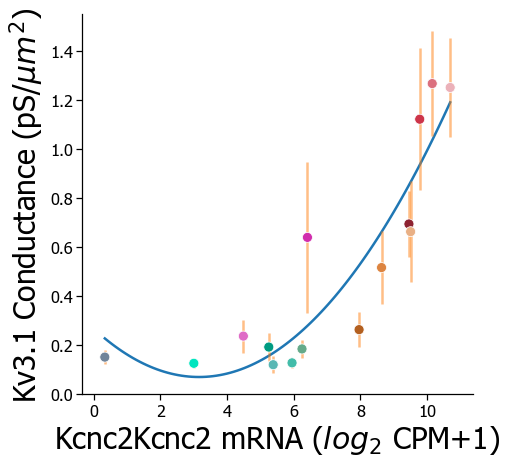

In [117]:
graph_conductance_exp('gbar_Kv3_1', 'Kcnc2', sep_layer_cre_parameter_df, 'Kcnc2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

In [118]:
create_graph_spec('gbar_Kv3_1', 'Kcnn1', sep_layer_cre_parameter_df)

,gbar_Kv3_1,84036
Htr3a L2/3,0.235402,0.739596
Htr3a L5,0.638604,0.516046
Nr5a1 L4,0.126182,1.243609
Ntsr1 L6,0.149601,1.554185
Pvalb L2/3,0.693312,1.068842
Pvalb L4,1.121246,1.099674
Pvalb L5,1.266772,0.702511
Pvalb L6,1.250779,1.642425
Rbp4 L4,0.190676,1.903054
Rbp4 L5,0.124294,2.208721


In [119]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_multiple(parameter_type, gene_symbols, df, xlabel, ylabel):
    if len(gene_symbols) == 4:
        i = 141
    elif len(gene_symbols) == 3:
        i = 141
    elif len(gene_symbols) == 2:
        i = 141
    plt.figure(figsize=(20, 5))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    for gene_symbol in gene_symbols:
        gene_id = entrenz_symbol_s[entrenz_symbol_s['gene_symbol'] == gene_symbol].index[0]
        graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
        plt.subplot(i)
        plt.tight_layout()
        graph_conductance_exp(parameter_type, gene_symbol, sep_layer_cre_parameter_df, 'Kcnc2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

#         std_cre = sem.loc[cre_color_inc_4,:]
#         errors = std_cre[parameter_type]
#         inv_errors = 1/errors

#         graph_spec.sort_values(by=[gene_id], inplace = True)
#         mini = graph_spec.iloc[0, :][gene_id]
#         maxi = graph_spec.iloc[14, :][gene_id]

#         graph_spec = create_graph_spec(parameter_type, gene_symbol, df)

#         plt.subplot(i)
#         plt.tight_layout()
#         z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=2)
#         p = np.poly1d(z)
#         xp = np.linspace(mini, maxi, 100)
#         _ = plt.plot(xp, p(xp), '-', zorder=1)
        

#         ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
#         if i != len(gene_symbols):
#             ax.get_legend().set_visible(False)
#         else:
#             plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
#         plt.rcParams['font.family'] = 'sans-serif'
#         plt.rcParams['font.sans-serif'] = ['Tahoma']
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.yaxis.set_ticks_position('left')
#         ax.xaxis.set_ticks_position('bottom')

#         ax.xaxis.label.set_size(15)
#         ax.yaxis.label.set_size(15)
#         ax.set(xlabel=gene_symbol+xlabel, ylabel=ylabel)

#         # Find the x,y coordinates for each point
#         x_coords = []
#         y_coords = []
#         for point_pair in ax.collections:
#             for x, y in point_pair.get_offsets():
#                 x_coords.append(x)
#                 y_coords.append(y)

#         ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
#         plt.tight_layout()
        i = i + 1
    plt.savefig("{}.svg".format(parameter_type), format="svg")
    plt.show()


In [120]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp_inc_4(parameter_type, gene_symbols, df, xlabel, ylabel):
    if len(gene_symbols) == 4:
        i = 141
    elif len(gene_symbols) == 3:
        i = 141
    elif len(gene_symbols) == 2:
        i = 141
    plt.figure(figsize=(20, 5))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    for gene_symbol in gene_symbols:
        gene_id = entrenz_symbol_s[entrenz_symbol_s['gene_symbol'] == gene_symbol].index[0]
        graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 

        std_cre = sem.loc[cre_color_inc_4,:]
        errors = std_cre[parameter_type]
        inv_errors = 1/errors

        graph_spec.sort_values(by=[gene_id], inplace = True)
        mini = graph_spec.iloc[0, :][gene_id]
        maxi = graph_spec.iloc[14, :][gene_id]

        graph_spec = create_graph_spec(parameter_type, gene_symbol, df)

        plt.subplot(i)
        plt.tight_layout()
        z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=2)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        _ = plt.plot(xp, p(xp), '-', zorder=1)
        

        ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
        if i != len(gene_symbols):
            ax.get_legend().set_visible(False)
        else:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Tahoma']
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        ax.set(xlabel=gene_symbol+xlabel, ylabel=ylabel)

        # Find the x,y coordinates for each point
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
        plt.tight_layout()
        i = i + 1
    plt.savefig("{}.svg".format(parameter_type), format="svg")
    plt.show()


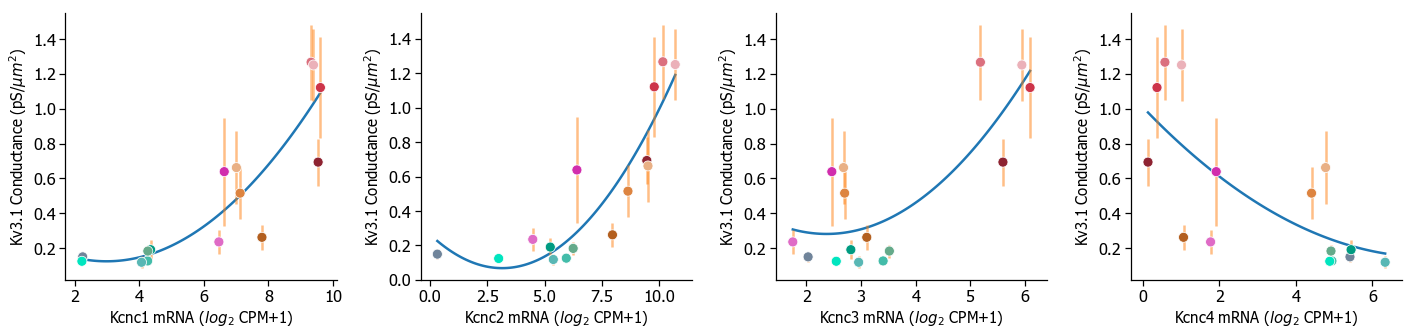

StopIteration: 

<Figure size 1440x504 with 1 Axes>

In [123]:
graph_conductance_exp_inc_4('gbar_Kv3_1', ['Kcnc1','Kcnc2', 'Kcnc3', 'Kcnc4'], sep_layer_cre_parameter_df, ' mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')
histo_corr_new('gbar_Kv3_1', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Kv3.1'),'Spearman')

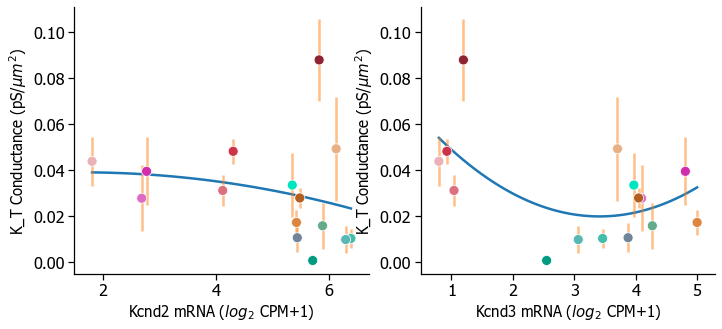

In [189]:
graph_conductance_exp_inc_4('gbar_K_T', ['Kcnd2', 'Kcnd3'], sep_layer_cre_parameter_df, ' mRNA ($log_2$ CPM+1)', 'K_T Conductance (pS/$\mu m^2$)')

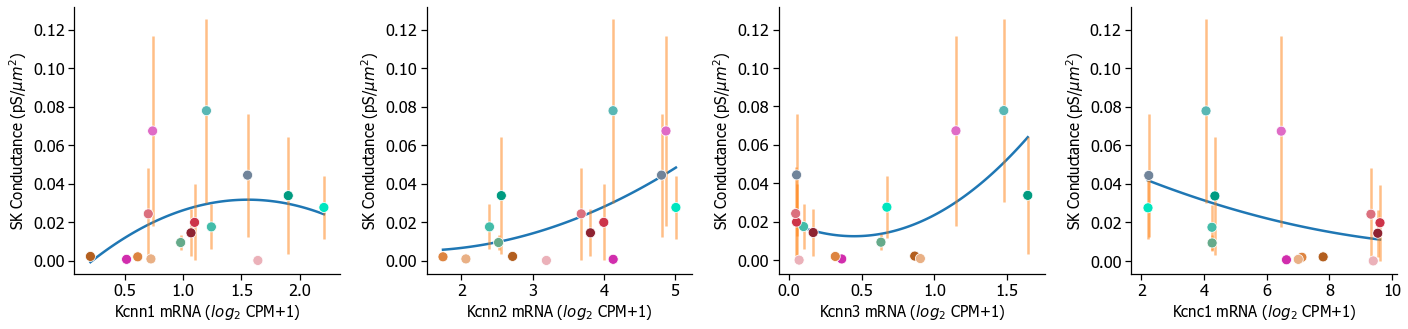

In [190]:
graph_conductance_exp_inc_4('gbar_SK', ['Kcnn1', 'Kcnn2', 'Kcnn3', 'Kcnc1'], sep_layer_cre_parameter_df, ' mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)')

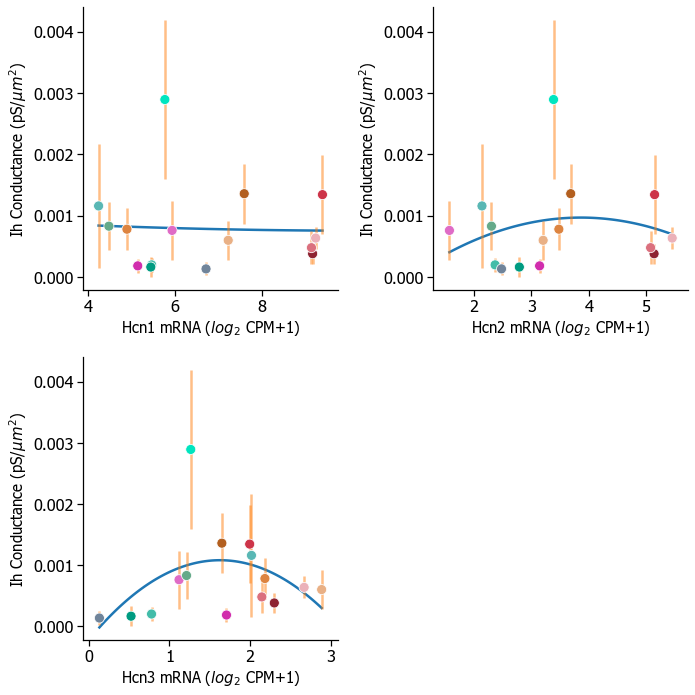

In [170]:
graph_conductance_exp_inc_4('gbar_Ih', ['Hcn1', 'Hcn2', 'Hcn3'], sep_layer_cre_parameter_df, ' mRNA ($log_2$ CPM+1)', 'Ih Conductance (pS/$\mu m^2$)')

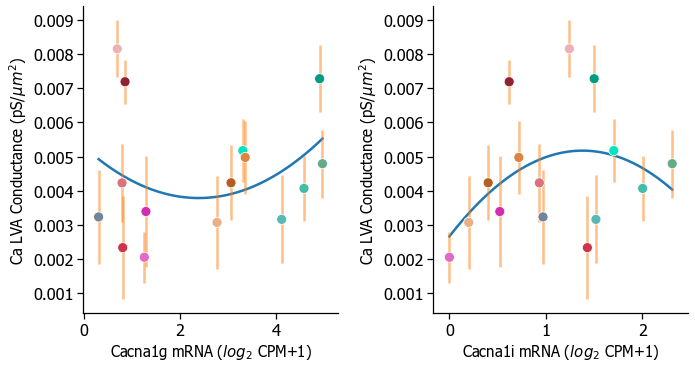

In [171]:
graph_conductance_exp_inc_4('gbar_Ca_LVA', ['Cacna1g', 'Cacna1i'], sep_layer_cre_parameter_df, ' mRNA ($log_2$ CPM+1)', 'Ca LVA Conductance (pS/$\mu m^2$)')

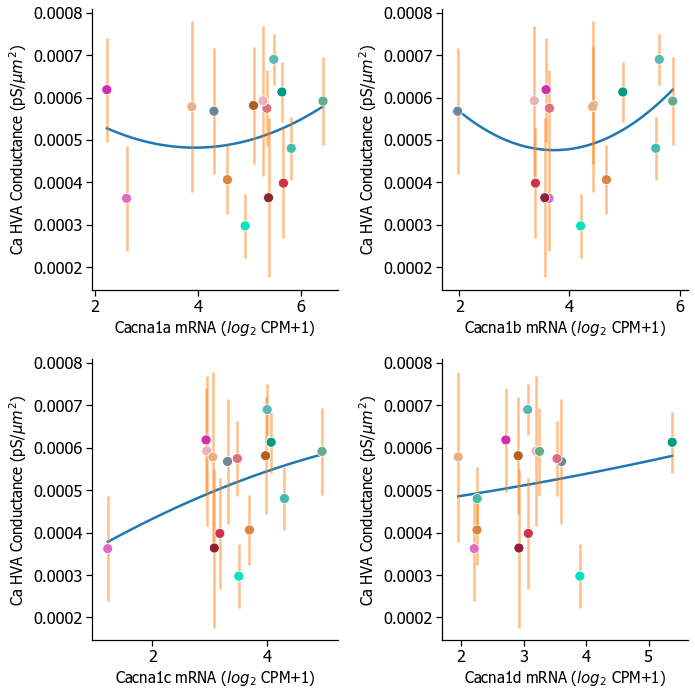

In [172]:
graph_conductance_exp_inc_4('gbar_Ca_HVA', ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d'], sep_layer_cre_parameter_df, ' mRNA ($log_2$ CPM+1)', 'Ca HVA Conductance (pS/$\mu m^2$)')

In [104]:
#Graphing scatterplot of conductance and transcriptomics
def abs_graph_conductance_exp_inc_4(parameter_type, gene_symbols, df, xlabel, ylabel):
    if len(gene_symbols) == 4:
        i = 221
    elif len(gene_symbols) == 3:
        i = 221
    elif len(gene_symbols) == 2:
        i = 221
    plt.figure(figsize=(10, 10))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    for gene_symbol in gene_symbols:
        gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
        graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 

        std_cre = abs_sem.loc[cre_color_inc_4,:]
        errors = std_cre[parameter_type]
        inv_errors = 1/errors

        graph_spec.sort_values(by=[gene_id], inplace = True)
        mini = graph_spec.iloc[0, :][gene_id]
        maxi = graph_spec.iloc[14, :][gene_id]

        graph_spec = create_graph_spec(parameter_type, gene_symbol, df)

        plt.subplot(i)
        plt.tight_layout()
        z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=2, w=inv_errors)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        _ = plt.plot(xp, p(xp), '-', zorder=1)
        

        ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
        if i != len(gene_symbols):
            ax.get_legend().set_visible(False)
        else:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Tahoma']
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        ax.set(xlabel=gene_symbol+xlabel, ylabel=ylabel)

        # Find the x,y coordinates for each point
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
        plt.tight_layout()
        i = i + 1
    plt.savefig("{}.svg".format(parameter_type), format="svg")
    plt.show()


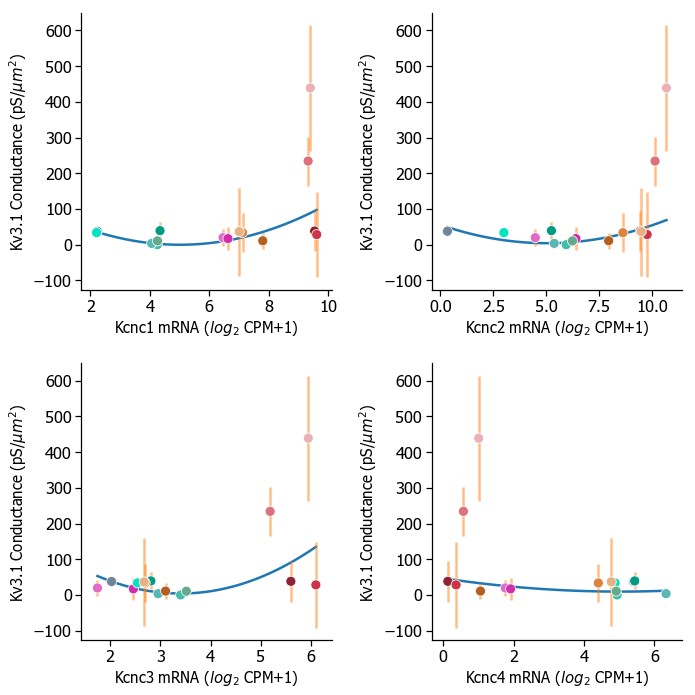

In [88]:
abs_graph_conductance_exp_inc_4('abs_gbar_Kv3_1', ['Kcnc1','Kcnc2', 'Kcnc3', 'Kcnc4'], abs_parameter_df, ' mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')

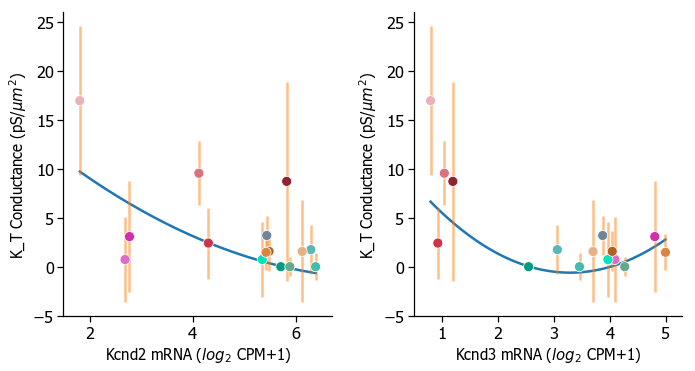

In [89]:
abs_graph_conductance_exp_inc_4('abs_gbar_K_T', ['Kcnd2', 'Kcnd3'], abs_parameter_df, ' mRNA ($log_2$ CPM+1)', 'K_T Conductance (pS/$\mu m^2$)')

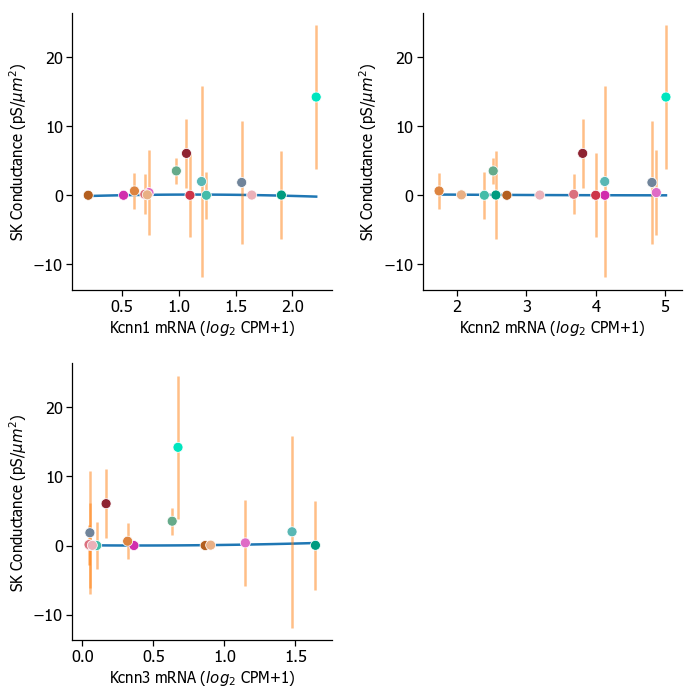

In [90]:
abs_graph_conductance_exp_inc_4('abs_gbar_SK', ['Kcnn1', 'Kcnn2', 'Kcnn3'], abs_parameter_df, ' mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)')

In [211]:
abs_graph_conductance_exp_inc_4('abs_gbar_Ih', ['Hcn1', 'Hcn2', 'Hcn3', 'Hcn4'], abs_parameter_df, ' mRNA ($log_2$ CPM+1)', 'Ih Conductance (pS/$\mu m^2$)')

NameError: name 'abs_graph_conductance_exp_inc_4' is not defined

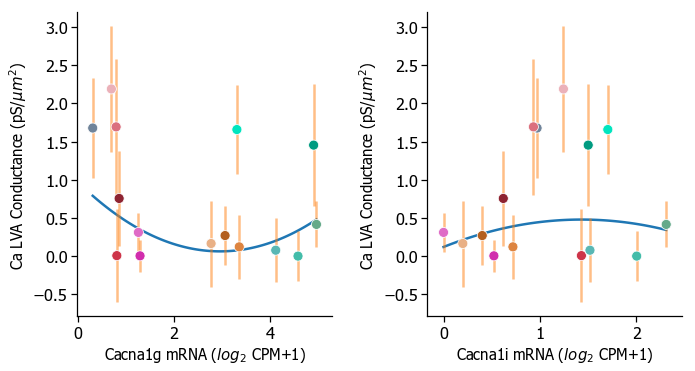

In [92]:
abs_graph_conductance_exp_inc_4('abs_gbar_Ca_LVA', ['Cacna1g', 'Cacna1i'], abs_parameter_df, ' mRNA ($log_2$ CPM+1)', 'Ca LVA Conductance (pS/$\mu m^2$)')

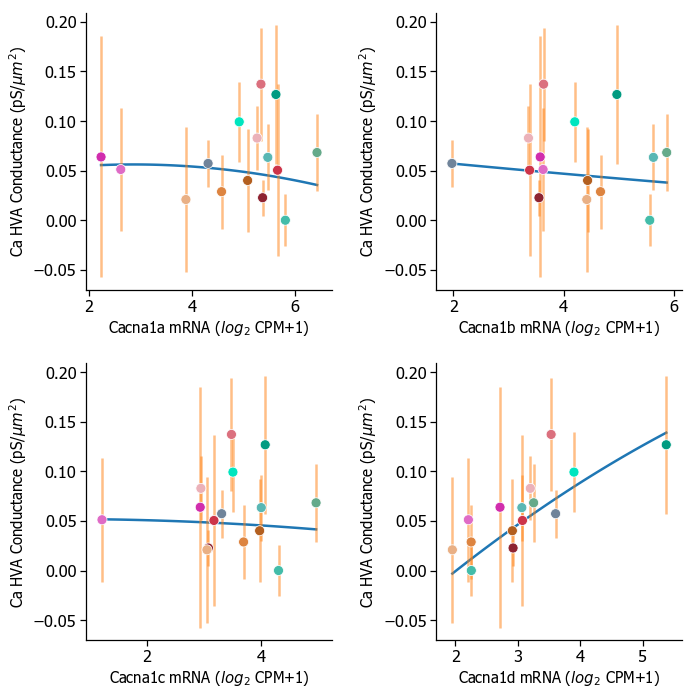

In [93]:
abs_graph_conductance_exp_inc_4('abs_gbar_Ca_HVA', ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d'], abs_parameter_df, ' mRNA ($log_2$ CPM+1)', 'Ca HVA Conductance (pS/$\mu m^2$)')

In [122]:
related_RNA = {}
related_RNA['gbar_Kv3_1'] = ['Kcnc1', 'Kcnc2', 'Kcnc3', 'Kcnc4']
related_RNA['gbar_K_T'] = ['Kcnd2', 'Kcnd3']
related_RNA['gbar_SK'] = ['Kcnn1', 'Kcnn2', 'Kcnn3']
related_RNA['gbar_Ih'] = ['Hcn1', 'Hcn2', 'Hcn3']
related_RNA['gbar_Ca_HVA'] = ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d']
related_RNA['gbar_Ca_LVA'] = ['Cacna1g', 'Cacna1i']

abs_related_RNA = {}
abs_related_RNA['abs_gbar_Kv3_1'] = ['Kcnc1', 'Kcnc2', 'Kcnc3', 'Kcnc4']
abs_related_RNA['abs_gbar_K_T'] = ['Kcnd2', 'Kcnd3']
abs_related_RNA['abs_gbar_SK'] = ['Kcnn1', 'Kcnn2', 'Kcnn3']
abs_related_RNA['abs_gbar_Ih'] = ['Hcn1', 'Hcn2', 'Hcn3']
abs_related_RNA['abs_gbar_Ca_HVA'] = ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d']
abs_related_RNA['abs_gbar_Ca_LVA'] = ['Cacna1g', 'Cacna1i']

def create_matrix(parameter, abs_spearman_dict):
    d = {"correlation": list(abs_spearman_dict[parameter].values()), "symbol": list(abs_spearman_dict[parameter].keys())}
    test = pd.DataFrame(d)
    return test.sort_values(by=['correlation'])

def create_matrix_select(parameter, abs_spearman_dict, list_possible):
    d = {"symbol":[], "correlation":[]}
    i = 0
    check = list(abs_spearman_dict[parameter].keys())
    for stuff in list_possible:
        if stuff in check:
            correl = abs_spearman_dict[parameter][stuff]
            d['symbol'].append(stuff)
            d['correlation'].append(correl)
            i = i + 1
    test = pd.DataFrame(d)
    return test.sort_values(by=['correlation'])
 
def histo_corr_new(parameter, df, xlabel, ylabel, y_max_val = 1):
    test = create_matrix_select(parameter, df, gene_channel)
    sorted_test = test.sort_values(["correlation"], ascending=True)
    clrs = []
    pos = []
    label = []
    p = 0
    for item in sorted_test['symbol']:
        if item in related_RNA[parameter]:
            clrs.append('blue')
            pos.append(p)
            label.append(item)
            p += 1
        else:
            clrs.append('red')
            p += 1
    plt.figure(figsize=(20, 7))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    ax = sns.barplot(x = 'symbol', y='correlation', data=sorted_test ,palette = clrs)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
    ax.set(ylabel=ylabel)
    ax.axes.set_ylim([-y_max_val, y_max_val])
    location = test['correlation'].iloc[-1] /4
    
    for i in range(len(label)) :
        if i > 0:
            if pos[i] - pos[i-1] < 5:
                location = location + test['correlation'].iloc[-1] /4
        if (test[test['symbol']==label[i]]['correlation'].iloc[0]) < 0:
            
            ax.annotate(label[i],
                xy=(pos[i], 0), xycoords='data',
                xytext=(pos[i], location), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"),
                )
        else:
            ax.annotate(label[i], xy=(pos[i], 0), xycoords='data', xytext=(pos[i], -location), textcoords='data', arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"),
                )
    plt.show()
    
def abs_histo_corr_new(parameter, df, xlabel, ylabel):
    test = create_matrix_select(parameter, df, gene_channel)
    sorted_test = test.sort_values(["correlation"], ascending=True)
    clrs = []
    pos = []
    label = []
    p = 0
    for item in sorted_test['symbol']:
        if item in abs_related_RNA[parameter]:
            clrs.append('blue')
            pos.append(p)
            label.append(item)
            p += 1
        else:
            clrs.append('red')
            p += 1
    plt.figure(figsize=(20, 7))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    ax = sns.barplot(x = 'symbol', y='correlation', data=sorted_test ,palette = clrs)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.xaxis.label.set_size(30)
    ax.yaxis.label.set_size(30)
    ax.set(ylabel=ylabel)
    location = test['correlation'].iloc[-1] /4
    
    for i in range(len(label)) :
        if i > 0:
            if pos[i] - pos[i-1] < 5:
                location = location + test['correlation'].iloc[-1] /4
        if (test[test['symbol']==label[i]]['correlation'].iloc[0]) < 0:
            
            ax.annotate(label[i],
                xy=(pos[i], 0), xycoords='data',
                xytext=(pos[i], location), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"),
                )
        else:
            ax.annotate(label[i], xy=(pos[i], 0), xycoords='data', xytext=(pos[i], -location), textcoords='data', arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"),
                )
    plt.show()

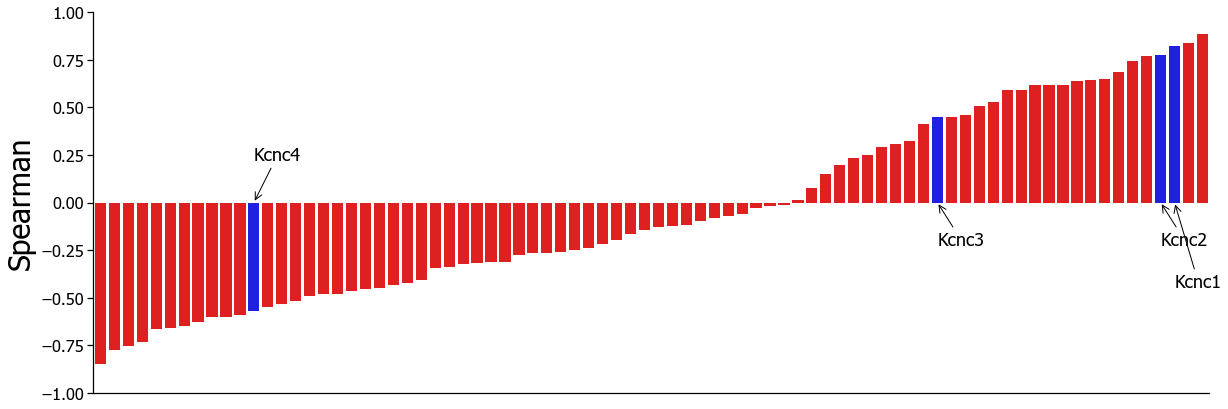

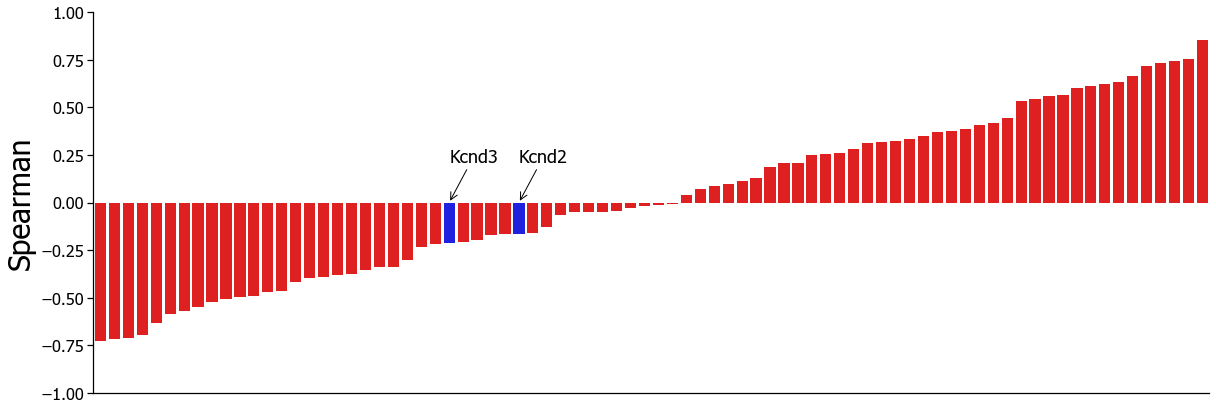

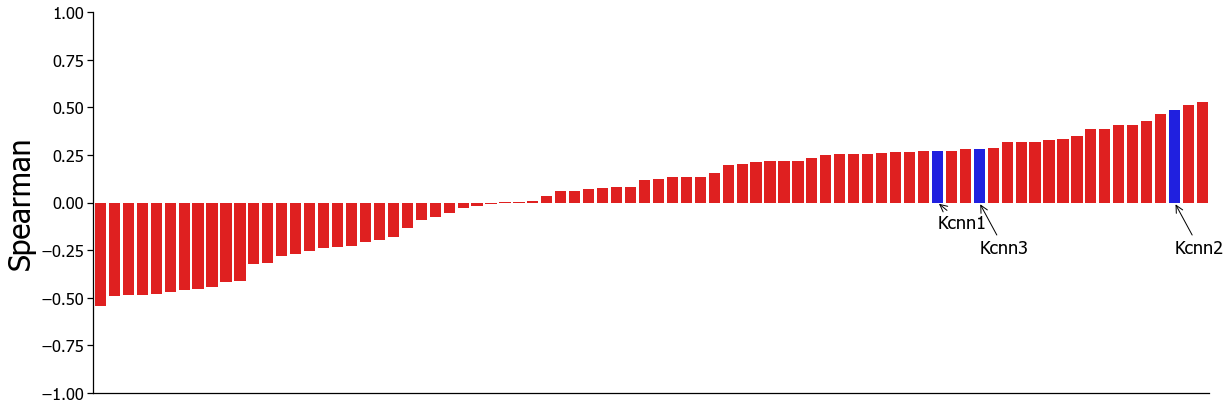

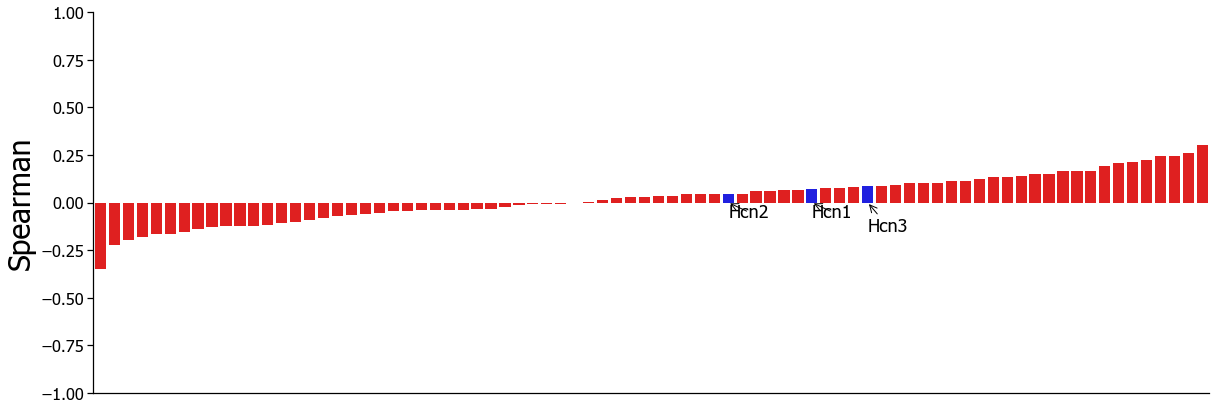

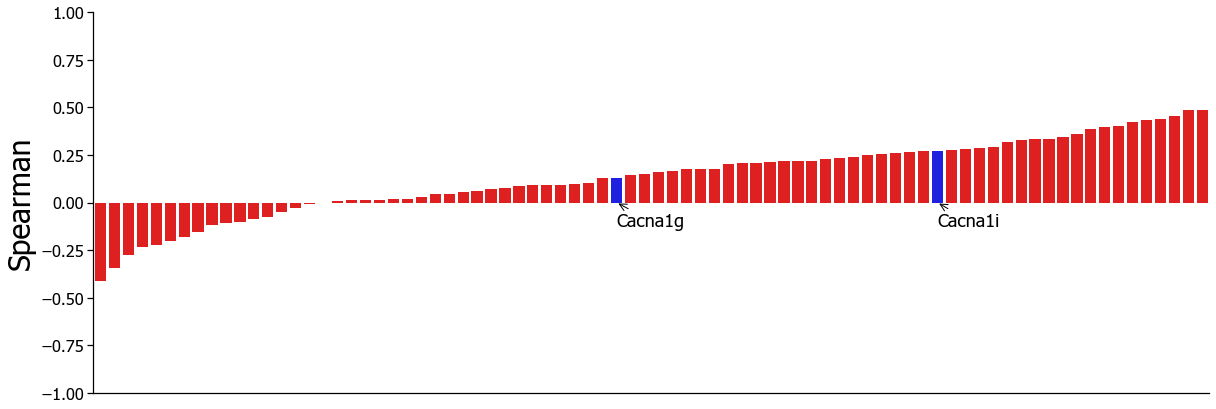

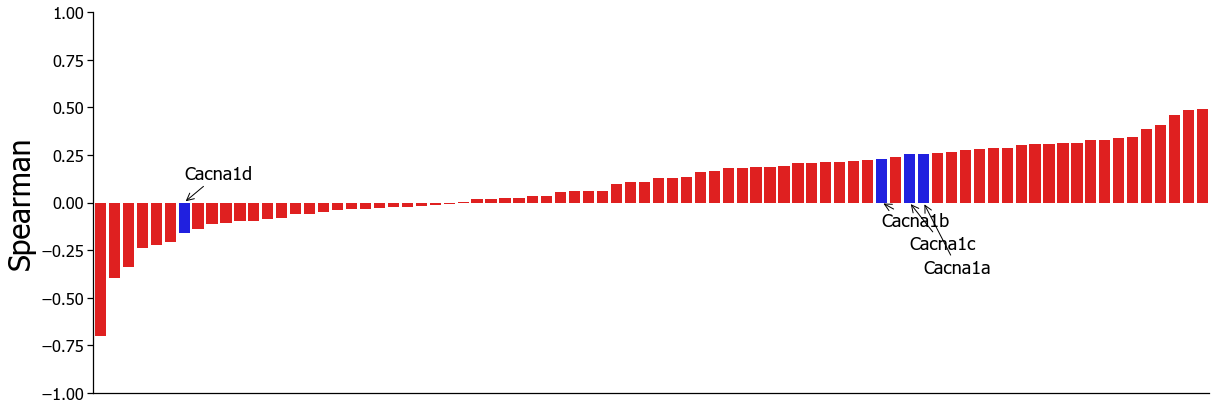

In [209]:
histo_corr_new('gbar_Kv3_1', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Kv3.1'),'Spearman')
histo_corr_new('gbar_K_T', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('K_T'),'Spearman')
histo_corr_new('gbar_SK', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('SK'),'Spearman')
histo_corr_new('gbar_Ih', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Ih'),'Spearman')
histo_corr_new('gbar_Ca_LVA', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Ca_LVA'),'Spearman')
histo_corr_new('gbar_Ca_HVA', sep_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Ca_HVA'),'Spearman')

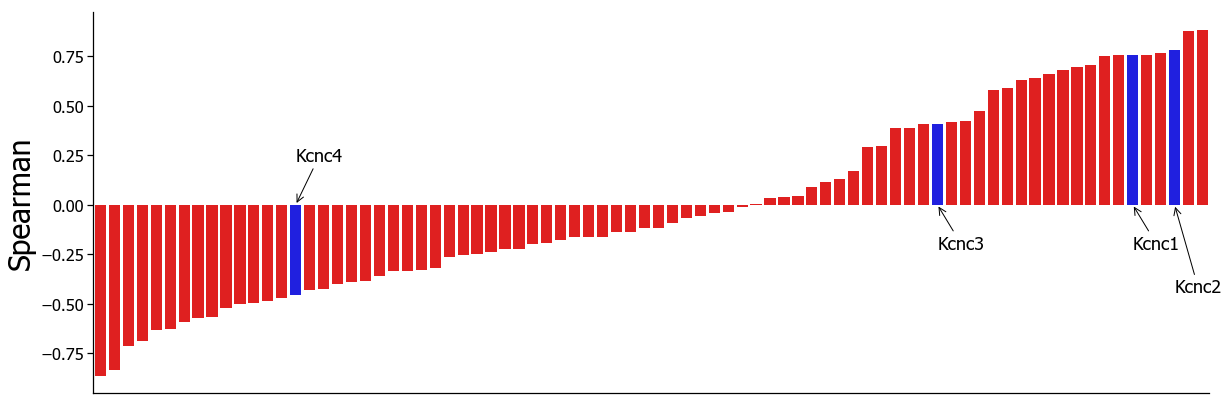

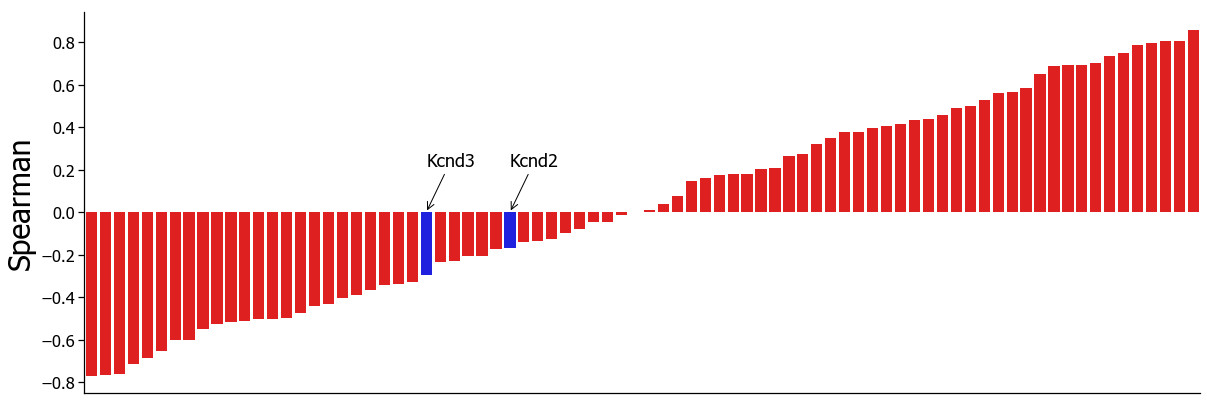

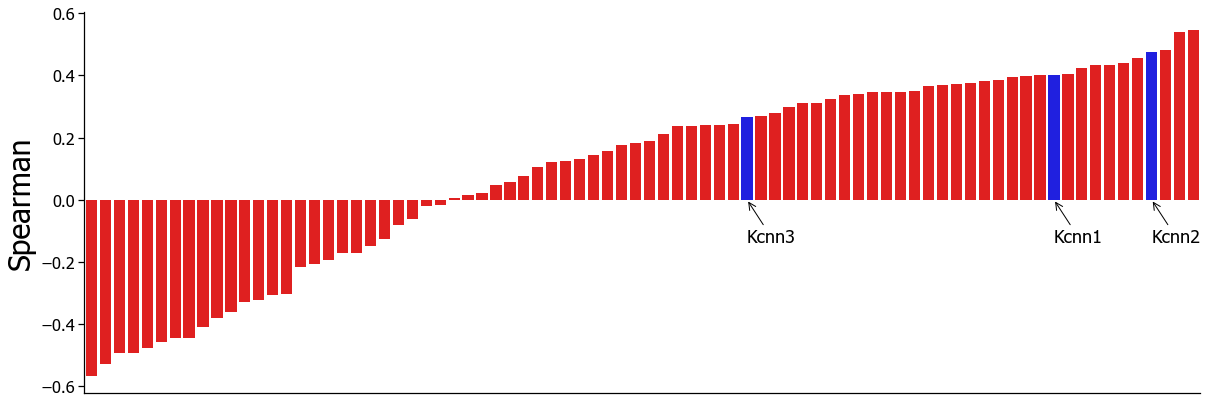

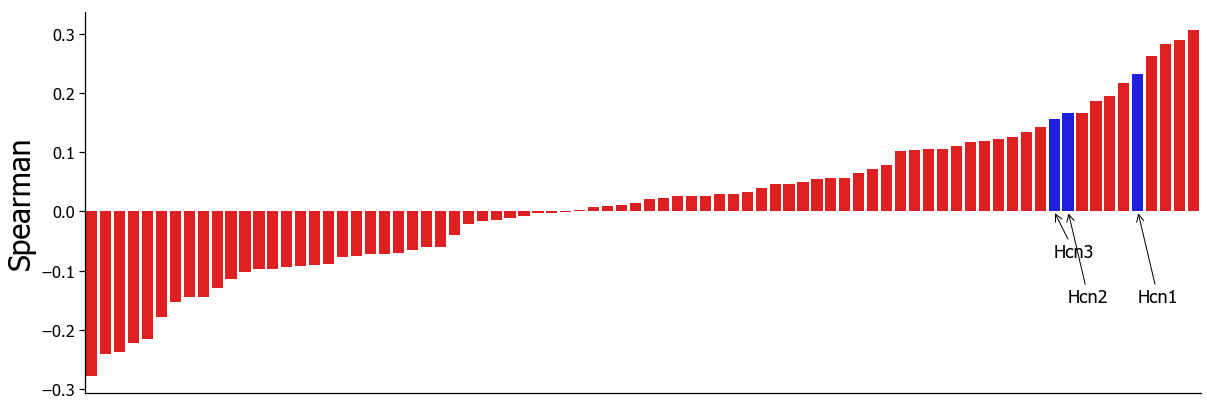

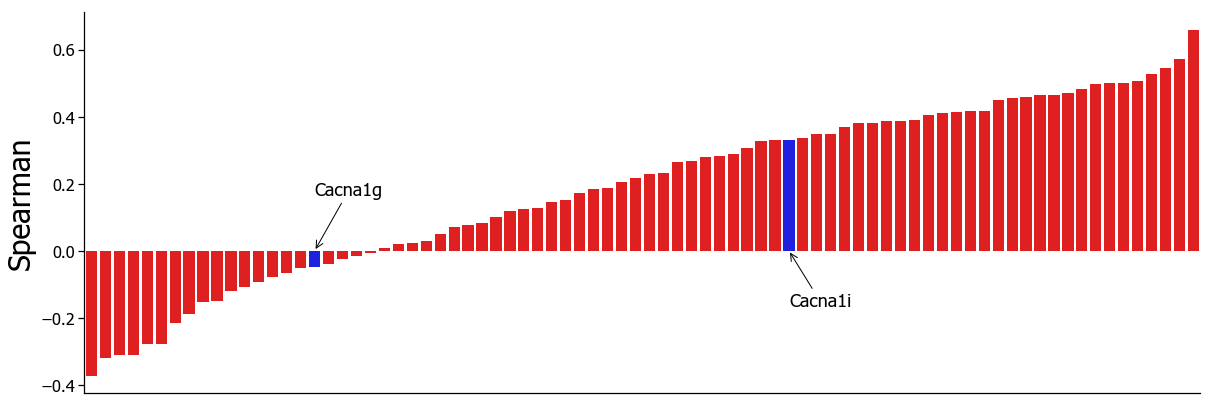

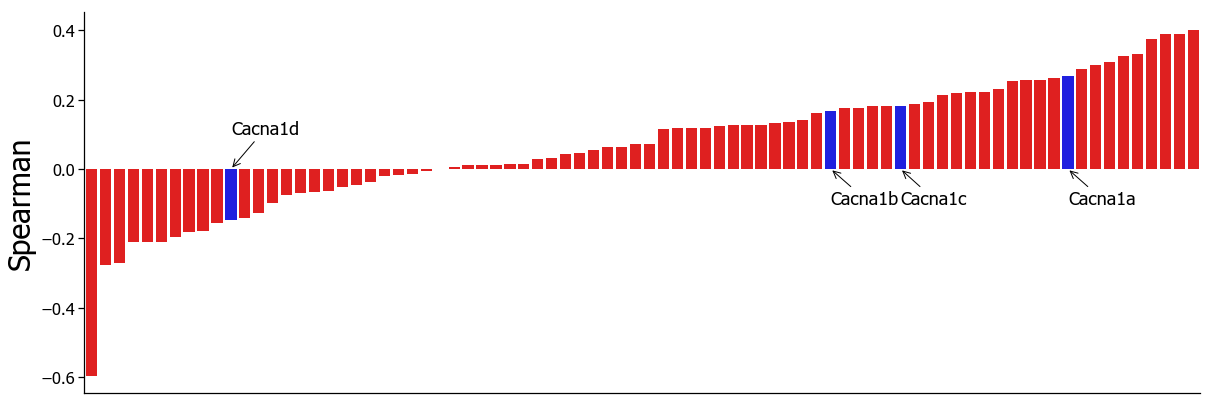

In [96]:
abs_histo_corr_new('abs_gbar_Kv3_1', abs_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Kv3.1'),'Spearman')
abs_histo_corr_new('abs_gbar_K_T', abs_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('K_T'),'Spearman')
abs_histo_corr_new('abs_gbar_SK', abs_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('SK'),'Spearman')
abs_histo_corr_new('abs_gbar_Ih', abs_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Ih'),'Spearman')
abs_histo_corr_new('abs_gbar_Ca_LVA', abs_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Ca_LVA'),'Spearman')
abs_histo_corr_new('abs_gbar_Ca_HVA', abs_spearman_corr_ranks, '{} Conductance \n Spearman Correlation'.format('Ca_HVA'),'Spearman')

In [97]:
def return_graph_conductance_exp_inh(parameter_type, gene_symbol, df, xlabel, ylabel):
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    std_cre = sem.loc[cre_color_inc_4,:]
    errors = std_cre[parameter_type]
    inv_errors = 1/errors
    
    plt.figure(figsize=(7, 7))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    
    cre_color_inc_4.sort()
    inh_or_exc = []
    for thing in cre_color_inc_4:
        inh_or_exc.append(thing[-3:])
    
    graph_spec['Address'] = inh_or_exc

    graph_spec.index = range(15)
    graph_spec.rename(columns={gene_id: gene_symbol}, inplace= True)

    
    ax = sns.lmplot(x=gene_symbol, y=parameter_type, hue="Address", data=graph_spec, truncate=True)

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Tahoma']
    
    
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    # Find the x,y coordinates for each point
    
    plt.show()
    

C:\Users\Allose\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 504x504 with 0 Axes>

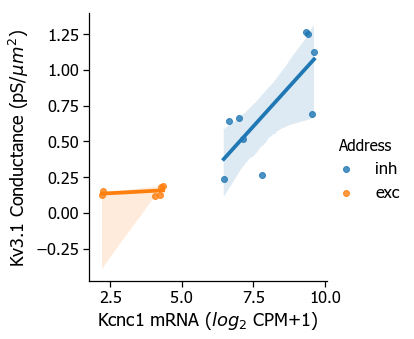

<Figure size 504x504 with 0 Axes>

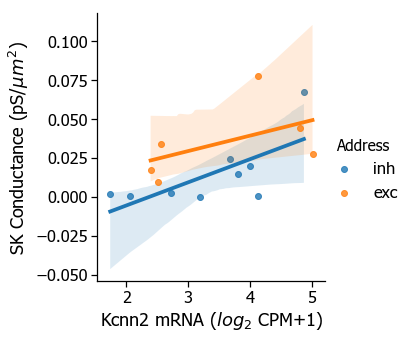

In [98]:
return_graph_conductance_exp_inh('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')
return_graph_conductance_exp_inh('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 'Kcnn2 mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)')

In [73]:
cre_color_inc_type = ['Htr3a-Cre_NO152__L2/3__inh',
             'Htr3a-Cre_NO152__L5__inh', 'Nr5a1-Cre__L4__exc',
             'Ntsr1-Cre_GN220__L6__exc',
             'Pvalb-IRES-Cre__L2/3__inh',
             'Pvalb-IRES-Cre__L4__inh',
             'Pvalb-IRES-Cre__L5__inh',
             'Pvalb-IRES-Cre__L6__inh',
             'Rbp4-Cre_KL100__L4__exc',
             'Rbp4-Cre_KL100__L5__exc',
             'Scnn1a-Tg2-Cre__L4__exc',
             'Scnn1a-Tg3-Cre__L2/3-L4__exc',
             'Sst-IRES-Cre__L1-L2/3__inh',
             'Sst-IRES-Cre__L5__inh',
             'Sst-IRES-Cre__L6__inh']

cre_line_palette_inc_type = {'Htr3a L2/3':"#DF6BC6",
                    'Htr3a L5':"#D12DAD",
                             'Nr5a1-Cre__L4__exc':"#43BCA9",
                    'Ntsr1-Cre_GN220__L6__exc':"#70849A",
                    'Pvalb-IRES-Cre__L2/3__inh':"#8E2331",
                    'Pvalb-IRES-Cre__L4__inh':"#CD3449",
                    'Pvalb-IRES-Cre__L5__inh':"#DB707E",
                    'Pvalb-IRES-Cre__L6__inh':"#EBB1b9",
                    'Rbp4-Cre_KL100__L4__exc':"#009B81",
                    'Rbp4-Cre_KL100__L5__exc':"#00E5BF",
                    'Scnn1a-Tg2-Cre__L4__exc':"#59B7B4",
                    'Scnn1a-Tg3-Cre__L2/3-L4__exc':"#65AA8A",
                    'Sst-IRES-Cre__L1-L2/3__inh':"#B35F1F",
                    'Sst-IRES-Cre__L5__inh':"#DD8440",
                    'Sst-IRES-Cre__L6__inh':"#E9B085"}

def create_cre_conductance_type(parameter_type, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_type , : ]
    return cre_conductance_filtered

def create_gene_spec_filtered_type(gene_symbol):
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_type])
    return gene_spec_filtered, gene_id

def rename_graph_spec_type(graph_spec):
    graph_spec.rename(index = {"Htr3a-Cre_NO152__L5__inh":"Htr3a L5", 
                               'Htr3a-Cre_NO152__L2/3__inh':'Htr3a L2/3',
                               'Nr5a1-Cre__L4__exc':'Nr5a1 L4',
                               'Ntsr1-Cre_GN220__L6__exc':'Ntsr1 L6',
             'Pvalb-IRES-Cre__L2/3__inh':'Pvalb L2/3',
             'Pvalb-IRES-Cre__L4__inh':'Pvalb L4',
             'Pvalb-IRES-Cre__L5__inh':'Pvalb L5',
             'Pvalb-IRES-Cre__L6__inh':'Pvalb L6',
             'Rbp4-Cre_KL100__L4__exc':'Rbp4 L4',
             'Rbp4-Cre_KL100__L5__exc':'Rbp4 L5',
             'Scnn1a-Tg2-Cre__L4__exc':'Scnn1a-Tg2 L4',
            'Scnn1a-Tg3-Cre__L2/3-L4__exc':'Scnn1a-Tg3 L2/3-L4',
                               'Sst-IRES-Cre__L1-L2/3__inh':'Sst L1-L2/3', 
             'Sst-IRES-Cre__L5__inh':'Sst L5',
             'Sst-IRES-Cre__L6__inh':'Sst L6'}, 
                                 inplace = True)
    
def create_graph_spec_type(parameter_type, gene_symbol, df):
    cre_conductance_filtered = create_cre_conductance_type(parameter_type, df)
   
    gene_spec_filtered, gene_id = create_gene_spec_filtered_type(gene_symbol)
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    
    rename_graph_spec_type(graph_spec)
    
    return graph_spec

def return_graph_conductance_exp_type(parameter_type, gene_symbol, df, xlabel, ylabel):
    
    gene_id = entrenz_symbol_s[entrenz_symbol_s == gene_symbol].index[0]
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    plt.figure(figsize=(7, 7))   
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    
    cre_color_inc_4.sort()
    c_type = []
    for thing in cre_color_inc_4:
        if thing[-3:] == 'exc':
            c_type.append('Pyr')
        elif thing[0:5] == 'Pvalb':
            c_type.append('PV')
        elif thing[0:3] == 'Sst':
            c_type.append('Sst')
        elif thing[0:5] == 'Htr3a':
            c_type.append('Htr3')

    graph_spec['Address'] = c_type
    print(graph_spec)
    ax = sns.lmplot(x=gene_id, y=parameter_type, hue="Address", data=graph_spec, truncate=True)

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Tahoma']
            
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    # Find the x,y coordinates for each point
    
    plt.show()
    

In [74]:
return_graph_conductance_exp_type('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')
return_graph_conductance_exp_type('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 'Kcnn2 mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)')

                    gbar_Kv3_1     16502 Address
Htr3a L2/3            0.235402  6.462288    Htr3
Htr3a L5              0.638604  6.628302    Htr3
Nr5a1 L4              0.126182  4.253329     Pyr
Ntsr1 L6              0.149601  2.239168     Pyr
Pvalb L2/3            0.693312  9.539327      PV
Pvalb L4              1.121246  9.610216      PV
Pvalb L5              1.266772  9.321005      PV
Pvalb L6              1.250779  9.395449      PV
Rbp4 L4               0.190676  4.345955     Pyr
Rbp4 L5               0.124294  2.214520     Pyr
Scnn1a-Tg2 L4         0.118571  4.064034     Pyr
Scnn1a-Tg3 L2/3-L4    0.182939  4.258513     Pyr
Sst L1-L2/3           0.261797  7.797611     Sst
Sst L5                0.515266  7.120628     Sst
Sst L6                0.661893  7.005162     Sst


KeyError: "['58520'] not in index"

<Figure size 504x504 with 0 Axes>